This notebook contains prototype code for the paper [Opinion Dynamics with Varying Susceptibility to Persuasion][2]. 


Author : [Charalampos E. Tsourakakis][1]  
Contact: [tsourolampis@gmail.com](mailto:tsourolampis@gmail.com) 

[1]: https://tsourakakis.com/
[2]: people.seas.harvard.edu/~babis/opinion_persuasion.pdf


# Network generators

In [1]:
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
def Gnp(n,p):
    ''' 
    @params: 
    n (int): number of nodes 
    p (double): edge probability
    
    @returns:
    G: Random binomial graph
    '''
    return nx.fast_gnp_random_graph(n,p)

In [3]:
def BA(n,m):
    '''
    @params: 
    n (int): number of nodes 
    m (double):  number of edges attached to incoming node
    
    @returns:
    G: preferential attachment random graph
    
    '''
    return nx.barabasi_albert_graph(n,m)

In [4]:
def readgraph(file,delim='\t'):
    f= open(file, 'rb')
    G= nx.read_edgelist(f,delimiter=delim,data='int')
    f.close()
    return G

Let's produce a couple of graphs, and visualize them. 

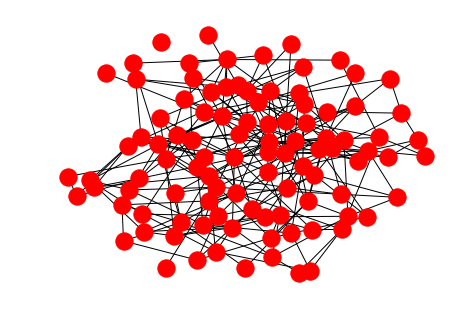

In [5]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

n = 100 
p = 0.05 
m = 1 
G = Gnp(n,p)
nx.draw(G,pos=nx.spring_layout(G)) # use spring layout

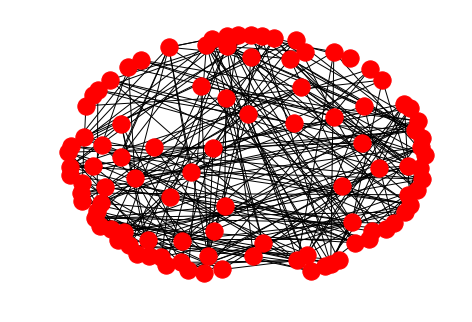

In [6]:
H = BA(n,m)
nx.draw(G,pos=nx.spring_layout(H)) # use spring layout

[40, 10, 10, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


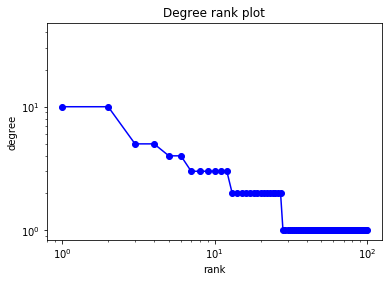

In [7]:
degree_sequence=sorted(nx.degree(H).values(),reverse=True) # degree sequence
dmax=max(degree_sequence)
print(degree_sequence)
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# Opinion generators  

We will use two types of distributions for generating initial opinions. 

In [8]:
import scipy as sp
from scipy.stats import uniform

In [9]:
def uniform_opinions(n):
    '''
    @params: 
    n (int): number of nodes 
    
    @returns:
    opinions: a vector of innate uar opinions
    opinions.sum() : total sum of opinions, in expectation n/2
    '''
    opinions = uniform.rvs(size=n)
    return opinions, opinions.sum() 

The second distribution is the power law distribution. 

In [10]:
from scipy.stats import powerlaw
def powerlaw_opinions(n,slope):
    '''
    @params: 
    n (int): number of nodes 
    slope  : power law slope 
    @returns:
    opinions: a vector of innate opinions sampled according to a power law distribution with a given slope 
    opinions.sum() : total sum of opinions 
    '''
    opinions = powerlaw.rvs(slope, size=n)
    return opinions, opinions.sum() 

[ 0.88212941  0.64438622  0.26693427]
1.79344989709


(array([ 17.,  19.,  13.,  10.,  18.,  11.,   7.,   1.,   1.,   3.]),
 array([ 0.00393274,  0.09335496,  0.18277717,  0.27219939,  0.36162161,
         0.45104382,  0.54046604,  0.62988826,  0.71931048,  0.80873269,
         0.89815491]),
 <a list of 10 Patch objects>)

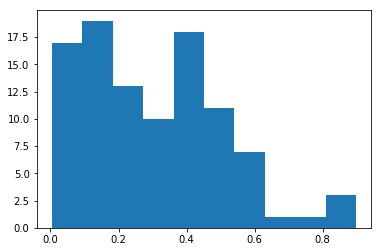

In [11]:
# example
s, x = uniform_opinions(3)
print(s)
print(x)
slope = 2
s,x = powerlaw_opinions(100,2)
plt.hist(1-s)


(array([  3.,   1.,   1.,   7.,  11.,  18.,  10.,  13.,  19.,  17.]),
 array([ 0.10184509,  0.19126731,  0.28068952,  0.37011174,  0.45953396,
         0.54895618,  0.63837839,  0.72780061,  0.81722283,  0.90664504,
         0.99606726]),
 <a list of 10 Patch objects>)

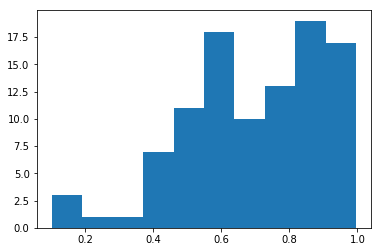

In [12]:
plt.hist(s)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math

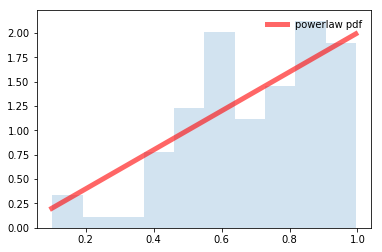

In [14]:
fig, ax = plt.subplots(1, 1)
y = np.linspace(powerlaw.ppf(0.01, slope),powerlaw.ppf(0.99, slope), 100)
ax.plot(y, powerlaw.pdf(y, slope),'r-', lw=5, alpha=0.6, label='powerlaw pdf')
ax.hist(s, normed=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

# Unbudgeted Opinion Optimization

In [15]:
from numpy.linalg import inv 

In [16]:
def num_deriv_Stubborness(n,Stub,P,s,index,h=0.001):
    '''
    @params: 
    n (int): number of nodes 
    Stub   : diagonal matrix containing stubbornness parameters 
    P      : random walk matrix 
    s      : innate opinions vector 
    index  : node index 
    h      : perturbation step, used for numerical computation of the derivative
    
    @returns:
    df     : derivative with respect to stubbornness/Susceptibility parameter of node index  
    '''
    d = np.zeros(n)
    d[index] = h
    D = np.diag(d)
    allones = np.ones((1,n)) 
    I = np.identity(n)
    z = np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I,Stub), P) ) ), Stub ), s) #equilibrium 
    eqsum = np.dot(allones,np.transpose(z))  #sum 
    Y = np.add(Stub, D) 
    z_h = np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I,Y), P) ) ), Y ), s) #equilibrium 
    eqsum_h = np.dot(allones,np.transpose(z_h)) 
    df = (eqsum_h-eqsum)/h 
    return df 

In [17]:
def opinion_function(n,X,P,s):
    allones = np.ones((1,n)) 
    I = np.identity(n)
    z = np.dot( inv( np.subtract( X, np.dot(np.subtract(X,I), P) ) ), s ) #equilibrium 
    eqsum = np.dot(allones,np.transpose(z))  #sum 
    return eqsum


def opinion_function_Stub(n,Stub,P,s):
    allones = np.ones((1,n)) 
    I = np.identity(n)     
    z = np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I,Stub), P) ) ), Stub ),s) #equilibrium 
    eqsum = np.dot(allones,np.transpose(z))  #sum 
    return eqsum

In [18]:
def grad_descent_line_search(A,n,s, low,high,alpha=0.1,beta=0.8,MAXT=100000, initial_alpha_values=None):
    if(initial_alpha_values is None):
        initial_alpha_values =  uniform.rvs(size=n)
    threshold = 10**(-10)
    allones = np.ones((n,1)) 
    ones = np.ones(n)
    I = np.identity(n)
    y = np.add(s,allones)     
    P = np.dot(np.diag(np.array(  np.divide(1,np.sum(A,1)).flatten()).flatten()), A)
    print("RW matrix computed..")
    
    Stub = np.diag( initial_alpha_values )
    Stub_init = Stub

    initial_sum_opinions = s.sum()      
    obj_before = np.dot( np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I, Stub), P) ) ), Stub ), s), allones) #1^T z, z = equilibrium 
    print("Initial objective computed")
    T = 0
    df = 1
    h = 0.1
    while(T<=MAXT and math.fabs(df) >=threshold):
        for i in range(n):
            df = num_deriv_Stubborness(n,Stub,P,s,i,h)
            eta = 1 
            Stub[i,i] =  Stub[i,i] - eta*df
            if( Stub[i,i] < low ):
                Stub[i,i] = low
            if(Stub[i,i] > high):
                Stub[i,i] = high
        T += 1    
    Stub_after = Stub
    final_alpha_values =  np.diag(Stub) 
    obj_after = np.dot( np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I, Stub), P) ) ), Stub ), s), allones) #1^T z, z = equilibrium 
    return final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after

In [19]:
def fast_num_deriv_Stubborness(n,X,Stub,z,s,index,h=0.001):
    I = np.identity(n)
    u = np.zeros(n)
    u[index] = np.sqrt(h) 
    # Sherman Morisson formula 
    Z = X - np.multiply(np.multiply(X, np.transpose(u)), np.multiply(u,X))/(1+np.multiply(np.multiply(u,X), np.transpose(u))) 
    allones = np.ones((1,n)) 
    eqsum = np.dot(allones,np.transpose(z))  #sum 
    d = np.zeros(n)
    d[index] = h
    D = np.diag(d) #=uu^T
    Y = np.add(Stub, D) 
    z_h = np.dot(np.dot(Z, np.add(Stub,D) ),s)
    eqsum_h = np.dot(allones,np.transpose(z_h)) 
    df = (eqsum_h-eqsum)/h 
    return df, z_h, Z

In [20]:
def fast_grad_descent_line_search(A,n,s, low,high,alpha=0.1,beta=0.8,MAXT=100000, initial_alpha_values=None):
    if(initial_alpha_values is None):
        initial_alpha_values =  uniform.rvs(size=n)
    threshold = 10**(-10)
    allones = np.ones((n,1)) 
    ones = np.ones(n)
    I = np.identity(n)
    y = np.add(s,allones)     
    P = np.dot(np.diag(np.array(  np.divide(1,np.sum(A,1)).flatten()).flatten()), A)
    print("RW matrix computed..")
    initial_alpha_values =  uniform.rvs(size=n)
    Stub = np.diag( initial_alpha_values )
    Stub_init = Stub

    initial_sum_opinions = s.sum()      
    X = inv( np.subtract( I, np.dot(np.subtract(I, Stub), P) ) )
    z = np.dot( np.dot( X, Stub ), s) 
    obj_before = np.dot( z, allones) #1^T z, z = equilibrium 
    print("Initial objective computed")
    T = 0
    df = 1
    h = 0.1

    while(T<=MAXT and math.fabs(df) >=threshold):
        print('Iteration'+repr(T)+" out of "+repr(MAXT))
        for i in range(n):
            df, z_h, Z = fast_num_deriv_Stubborness(n,X,Stub,z,s,i,h=0.001)
            eta = 1 
            Stub[i,i] =  Stub[i,i] - eta*df
            X = Z 
            z = z_h 
            if( Stub[i,i] < low ):
                Stub[i,i] = low
                X = inv( np.subtract( I, np.dot(np.subtract(I, Stub), P) ) )
            if(Stub[i,i] > high):
                Stub[i,i] = high
                X = inv( np.subtract( I, np.dot(np.subtract(I, Stub), P) ) )
        T += 1    
    Stub_after = Stub
    final_alpha_values =  np.diag(Stub) 
    obj_after = np.dot( np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I, Stub), P) ) ), Stub ), s), allones) #1^T z, z = equilibrium 
    return final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after

In [21]:
def fast_opinion_minimization(A,n,s,low,high,alpha=0.1,beta=0.1,MAXT=100000):
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = fast_grad_descent_line_search(A,n,s,low,high,alpha,beta,MAXT);
    return final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after  

def fast_opinion_maximization(A,n,s,low,high,alpha=0.1,beta=0.1,MAXT=100000): 
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = fast_grad_descent_line_search(A,n,1-s,low,high,alpha,beta,MAXT);
    obj_before = n - obj_before;
    obj_after  = n - obj_after;
    return final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after  

In [22]:
def opinion_minimization(A,n,s,low,high,alpha=0.1,beta=0.1,MAXT=100000):
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = grad_descent_line_search(A,n,s,low,high,alpha,beta,MAXT);
    return final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after  

def opinion_maximization(A,n,s,low,high,alpha=0.1,beta=0.1,MAXT=100000): 
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after =grad_descent_line_search(A,n,1-s,low,high,alpha,beta,MAXT);
    obj_before = n - obj_before;
    obj_after  = n - obj_after;
    return final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after  

# Toy examples

In [23]:
A = np.matrix('0 1; 1 0') 
n = 2 
ones = np.ones(n)
s, ign = uniform_opinions(n) 
P = np.dot( np.diag(np.array(  np.divide(1,np.sum(A,1)).flatten()).flatten())  , A) 
allones = np.ones((n,1)) 
I = np.identity(n)
a = np.multiply(np.ones(n)*10, uniform.rvs(size=n))
X = np.diag( a )
zs = np.dot( np.dot( inv( np.subtract( X, np.dot(np.subtract(X,I), P) ) ), s ), allones)
print(zs)
initial_alpha_values = np.divide( 1, np.diag(X) ) 
final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = grad_descent_line_search(A,n,s,low=0.1,high=1,alpha=0.1,beta=0.1,MAXT=5,initial_alpha_values=initial_alpha_values);
print(P)
print('Initial opinions')
print(s)
print("Initial obj. value"+ repr(obj_before)+"\n")
print("Final obj. value"+ repr(obj_after)+"\n")
      

print("********************************")
print("Initial stubborness parameters\n")
print(initial_alpha_values)
print("Optimal stubborness parameters\n")
print(final_alpha_values)
print("********************************")

[[ 1.48568112]]
RW matrix computed..
Initial objective computed
[[0 1]
 [1 0]]
Initial opinions
[ 0.36646777  0.73793633]
Initial obj. valuematrix([[ 1.48568112]])

Final obj. valuematrix([[ 0.7700824]])

********************************
Initial stubborness parameters

[ 0.11031092  2.5747172 ]
Optimal stubborness parameters

[ 1.   0.1]
********************************


In [24]:
# toy example
A = np.matrix('0 1; 1 0') 
n = 2 
ones = np.ones(n)
s, ign = uniform_opinions(n) 
P = np.dot( np.diag(np.array(  np.divide(1,np.sum(A,1)).flatten()).flatten())  , A) 
allones = np.ones((n,1)) 
I = np.identity(n)
a = np.multiply(np.ones(n)*10, uniform.rvs(size=n))
X = np.diag( a )
zs = np.dot( np.dot( inv( np.subtract( X, np.dot(np.subtract(X,I), P) ) ), s ), allones)
print(zs)
initial_alpha_values = np.divide( 1, np.diag(X) ) 
#print("********************************")
#print("Initial stubborness parameters\n")
#print(initial_alpha_values)
      
final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = fast_grad_descent_line_search(A,n,s,low=0.1,high=1,alpha=0.1,beta=0.1,MAXT=5,initial_alpha_values=initial_alpha_values);
print(P)
print('Initial opinions')
print(s)
#print(a)
# print
print("Initial obj. value"+ repr(obj_before))
print("Final obj. value"+ repr(obj_after))
      

#print("********************************")
print("Initial stubborness parameters")
print(initial_alpha_values)
print("Optimal stubborness parameters")
print(final_alpha_values)

[[ 0.42970439]]
RW matrix computed..
Initial objective computed
Iteration0 out of 5
Iteration1 out of 5
Iteration2 out of 5
Iteration3 out of 5
Iteration4 out of 5
Iteration5 out of 5
[[0 1]
 [1 0]]
Initial opinions
[ 0.15901632  0.3052993 ]
Initial obj. valuematrix([[ 0.54349263]])
Final obj. valuematrix([[ 0.46431561]])
Initial stubborness parameters
[ 0.43051294  0.95919414]
Optimal stubborness parameters
[ 0.1  0.1]


Let's try it on an Erdos Renyi graph before we move to our experiments

In [25]:
G = Gnp(100,0.1)
A = nx.to_numpy_matrix(G)

n = 100
s, ign = uniform_opinions(n) 
final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = grad_descent_line_search(A,n,s,low=0.1,high=1,alpha=0.1,beta=0.1,MAXT=30);
# print
print("Minimization")
print("Initial obj. value"+ repr(obj_before)+"\n")
print("Optimized obj. value"+ repr(obj_after)+"\n")
      
print("********************************")
print("Initial stubborness parameters\n")
print(initial_alpha_values)
      
print("********************************")
print("Optimal stubborness parameters\n")
print(final_alpha_values)

print("Maximization")
final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_maximization(A,n,s,0.01,1,0.1,0.1,30)
print("Initial obj. value"+ repr(obj_before)+"\n")
print("Optimized obj. value"+ repr(obj_after)+"\n")
      
print("********************************")
print("Initial stubborness parameters\n")
print(initial_alpha_values)
      
print("********************************")
print("Optimal stubborness parameters\n")
print(final_alpha_values)

print("Initial obj. value"+ repr(obj_before)+"\n")
print("Optimized obj. value"+ repr(obj_after)+"\n")

RW matrix computed..
Initial objective computed
Minimization
Initial obj. valuematrix([[ 54.15281457]])

Optimized obj. valuematrix([[ 25.49076536]])

********************************
Initial stubborness parameters

[ 0.70203983  0.56980682  0.2487433   0.14048181  0.64751102  0.47346746
  0.34346394  0.86712385  0.85502895  0.54645049  0.31387856  0.06465339
  0.13309645  0.0568859   0.23831047  0.3591802   0.64988026  0.01786407
  0.59333276  0.6606282   0.30770437  0.06223727  0.21878366  0.41552523
  0.4352462   0.45330713  0.51388113  0.3355771   0.91934672  0.00699527
  0.05683189  0.48167547  0.72964855  0.53441168  0.00593055  0.28509896
  0.55218342  0.98127877  0.09546793  0.00873464  0.24804455  0.96171075
  0.55646604  0.26053124  0.42262534  0.26439104  0.10347698  0.80952314
  0.10630371  0.62225345  0.29923034  0.70956723  0.59421307  0.79699809
  0.149612    0.85712785  0.10876628  0.74500978  0.7165036   0.11523729
  0.65506667  0.03173287  0.72112221  0.19003685  0.25

# Synthetic experiments

We experiment with preferential attachment and Erdos-Renyi graphs, and with power-law and uniform opinions. 

In [28]:
import math  

values = range(50,101,50)
MAXT= 100 
eta = 0.02 
alpha =0.1
beta = 0.1
low = 0.1
high = 1
# n,p,initial_sum_opinions, obj_before, obj_after
w, h = 6,len(values);
ER_MinResults = [[0 for x in range(w)] for y in range(h)]  
ER_MaxResults = [[0 for x in range(w)] for y in range(h)] 
ER_MinResults_PL = [[0 for x in range(w)] for y in range(h)]  
ER_MaxResults_PL = [[0 for x in range(w)] for y in range(h)] 

counter = 0
for n in values:
    print(n)
    p=2*math.log(n)/n;
    G = Gnp(n,p);
    A = nx.to_numpy_matrix(G)
    s, ign = uniform_opinions(n) 
    print('Minimization - Uniform initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);
    ER_MinResults[counter][0]=n;
    ER_MinResults[counter][1]=p;
    ER_MinResults[counter][2]=initial_sum_opinions;
    ER_MinResults[counter][3]=obj_before;
    ER_MinResults[counter][4]=obj_after;
    ER_MinResults[counter][5]=obj_before/obj_after;
    

    print('Maximization - Uniform initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_maximization(A,n,s,low,high,alpha,beta,MAXT);
    ER_MaxResults[counter][0]=n;
    ER_MaxResults[counter][1]=p;
    ER_MaxResults[counter][2]=initial_sum_opinions;
    ER_MaxResults[counter][3]=obj_before;
    ER_MaxResults[counter][4]=obj_after;
    ER_MaxResults[counter][5]=obj_after/obj_before;
          
          
    slope = 2
    s, ign = powerlaw_opinions(n,slope) 
    print('Minimization - Power law, slope 2, initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);
    ER_MinResults_PL[counter][0]=n;
    ER_MinResults_PL[counter][1]=slope;
    ER_MinResults_PL[counter][2]=initial_sum_opinions;
    ER_MinResults_PL[counter][3]=obj_before;
    ER_MinResults_PL[counter][4]=obj_after;
    ER_MinResults_PL[counter][5]=obj_before/obj_after;
          
    print('Maximization - Power law, slope 2, initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_maximization(A,n,s,low,high,alpha,beta,MAXT);
    ER_MaxResults_PL[counter][0]=n;
    ER_MaxResults_PL[counter][1]=slope;
    ER_MaxResults_PL[counter][2]=initial_sum_opinions;
    ER_MaxResults_PL[counter][3]=obj_before;
    ER_MaxResults_PL[counter][4]=obj_after;
    ER_MaxResults_PL[counter][5]=obj_after/obj_before;
    counter = counter + 1

50
Minimization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Maximization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Minimization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed
Maximization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed
100
Minimization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Maximization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Minimization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed
Maximization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed


In [29]:
print(ER_MinResults_PL)
print(ER_MinResults)
print(ER_MaxResults_PL)
print(ER_MaxResults)

[[50, 2, 31.847582486483493, matrix([[ 30.35759066]]), matrix([[ 19.92056656]]), matrix([[ 1.52393209]])], [100, 2, 64.141963661694717, matrix([[ 63.2553439]]), matrix([[ 41.25977497]]), matrix([[ 1.53309959]])]]
[[50, 0.15648092021712584, 19.974795061022334, matrix([[ 18.44421021]]), matrix([[ 9.94016174]]), matrix([[ 1.85552416]])], [100, 0.09210340371976183, 49.942241047004821, matrix([[ 53.33878876]]), matrix([[ 26.18212019]]), matrix([[ 2.0372219]])]]
[[50, 2, 18.152417513516507, matrix([[ 33.47765258]]), matrix([[ 41.17089068]]), matrix([[ 1.2298022]])], [100, 2, 35.858036338305283, matrix([[ 62.33517424]]), matrix([[ 82.55741273]]), matrix([[ 1.32441136]])]]
[[50, 0.15648092021712584, 30.025204938977666, matrix([[ 20.93986723]]), matrix([[ 34.36558798]]), matrix([[ 1.64115596]])], [100, 0.09210340371976183, 50.057758952995172, matrix([[ 51.74259271]]), matrix([[ 77.022964]]), matrix([[ 1.48857952]])]]


In [ ]:
# in case you want save the results, run this cell
np.savetxt('ER_MinResults_PL.txt', ER_MinResults_PL, delimiter='\t', newline='\n')
np.savetxt('ER_MinResults.txt', ER_MinResults, delimiter='\t', newline='\n')
np.savetxt('ER_MaxResults_PL.txt', ER_MaxResults_PL, delimiter='\t', newline='\n')
np.savetxt('ER_MaxResults.txt', ER_MaxResults, delimiter='\t', newline='\n')

In [30]:
# Barabasi-Albert

m=10; 
w, h = 6,len(values);
BA_MinResults = [[0 for x in range(w)] for y in range(h)]  
BA_MaxResults = [[0 for x in range(w)] for y in range(h)] 
BA_MinResults_PL = [[0 for x in range(w)] for y in range(h)]  
BA_MaxResults_PL = [[0 for x in range(w)] for y in range(h)] 

counter = 0
for n in values:
    print(n)
    G = BA(n,m); 
    A = nx.to_numpy_matrix(G)
    s, ign = uniform_opinions(n) 
    print('Minimization - Uniform initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);
    BA_MinResults[counter][0]=n;
    BA_MinResults[counter][1]=p;
    BA_MinResults[counter][2]=initial_sum_opinions;
    BA_MinResults[counter][3]=obj_before;
    BA_MinResults[counter][4]=obj_after;
    BA_MinResults[counter][5]=obj_before/obj_after;
    

    print('Maximization - Uniform initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_maximization(A,n,s,low,high,alpha,beta,MAXT);
    BA_MaxResults[counter][0]=n;
    BA_MaxResults[counter][1]=p;
    BA_MaxResults[counter][2]=initial_sum_opinions;
    BA_MaxResults[counter][3]=obj_before;
    BA_MaxResults[counter][4]=obj_after;
    BA_MaxResults[counter][5]=obj_after/obj_before;
          
          
    slope = 2
    s, ign = powerlaw_opinions(n,slope) 
    print('Minimization - Power law, slope 2, initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);
    BA_MinResults_PL[counter][0]=n;
    BA_MinResults_PL[counter][1]=slope;
    BA_MinResults_PL[counter][2]=initial_sum_opinions;
    BA_MinResults_PL[counter][3]=obj_before;
    BA_MinResults_PL[counter][4]=obj_after;
    BA_MinResults_PL[counter][5]=obj_before/obj_after;
          
    print('Maximization - Power law, slope 2, initial opinions')
    final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_maximization(A,n,s,low,high,alpha,beta,MAXT);
    BA_MaxResults_PL[counter][0]=n;
    BA_MaxResults_PL[counter][1]=slope;
    BA_MaxResults_PL[counter][2]=initial_sum_opinions;
    BA_MaxResults_PL[counter][3]=obj_before;
    BA_MaxResults_PL[counter][4]=obj_after;
    BA_MaxResults_PL[counter][5]=obj_after/obj_before;
    counter = counter + 1

50
Minimization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Maximization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Minimization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed
Maximization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed
100
Minimization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Maximization - Uniform initial opinions
RW matrix computed..
Initial objective computed
Minimization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed
Maximization - Power law, slope 2, initial opinions
RW matrix computed..
Initial objective computed


In [ ]:
np.savetxt('BA_MinResults_PL.txt', BA_MinResults_PL, delimiter='\t', newline='\n')
np.savetxt('BA_MaxResults_PL.txt', BA_MaxResults_PL, delimiter='\t', newline='\n')
np.savetxt('BA_MaxResults.txt', BA_MaxResults, delimiter='\t', newline='\n')
np.savetxt('BA_MinResults.txt', BA_MinResults, delimiter='\t', newline='\n')

In [31]:
print(BA_MinResults_PL)
print(BA_MaxResults_PL)
print(BA_MaxResults)
print(BA_MinResults)

[[50, 2, 32.306298522224139, matrix([[ 32.90690588]]), matrix([[ 23.76112284]]), matrix([[ 1.38490534]])], [100, 2, 66.893088216083726, matrix([[ 68.02354133]]), matrix([[ 43.96186435]]), matrix([[ 1.54733068]])]]
[[50, 2, 17.693701477775857, matrix([[ 31.14171103]]), matrix([[ 40.35739689]]), matrix([[ 1.29592741]])], [100, 2, 33.10691178391626, matrix([[ 68.27103291]]), matrix([[ 86.04515766]]), matrix([[ 1.2603465]])]]
[[50, 0.09210340371976183, 24.445070374808722, matrix([[ 25.0536219]]), matrix([[ 35.4730978]]), matrix([[ 1.41588701]])], [100, 0.09210340371976183, 50.361130690862019, matrix([[ 48.81876195]]), matrix([[ 73.36719133]]), matrix([[ 1.50284826]])]]
[[50, 0.09210340371976183, 25.554929625191278, matrix([[ 25.48291634]]), matrix([[ 12.37533139]]), matrix([[ 2.05917042]])], [100, 0.09210340371976183, 49.638869309137988, matrix([[ 46.37919757]]), matrix([[ 23.78053288]]), matrix([[ 1.95030102]])]]


# Real-world networks

In [32]:
import os 



def runRealData(directory, low=0.001, high=1,MAXT=30, alpha=0.1, beta=0.1):
    counter = 0 
    w, h = 6,4;
    Results = [[0 for x in range(w)] for y in range(h)]  
    for filename in os.listdir(directory):
        if filename.endswith(".txt") or filename.endswith(".edges"):
            print('Processing file '+directory+'/'+filename) 
            G = readgraph(directory+'/'+filename)
            A = nx.to_numpy_matrix(G)
            n = A.shape[0]
            
            s, ign = uniform_opinions(n) 
            final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_maximization(A,n,s,low,high,alpha,beta,MAXT);
            #final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = fast_opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);
            Results[counter][0]=n;
            Results[counter][1]=nx.number_of_edges(G);
            Results[counter][2]=initial_sum_opinions;
            Results[counter][3]=obj_before;
            Results[counter][4]=obj_after;
            Results[counter][5]=obj_before/obj_after;
            counter = counter +1 
            
            
            final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);         
            Results[counter][0]=n;
            Results[counter][1]=nx.number_of_edges(G);
            Results[counter][2]=initial_sum_opinions;
            Results[counter][3]=obj_before;
            Results[counter][4]=obj_after;
            Results[counter][5]=obj_before/obj_after;
            counter = counter +1 
            
            
            slope = 2 
            s, ign = powerlaw_opinions(n,slope) 
            final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_maximization(A,n,s,low,high,alpha,beta,MAXT);                        

            #final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = fast_opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);                        
            Results[counter][0]=n;
            Results[counter][1]=nx.number_of_edges(G);
            Results[counter][2]=initial_sum_opinions;
            Results[counter][3]=obj_before;
            Results[counter][4]=obj_after;
            Results[counter][5]=obj_before/obj_after;
            counter = counter +1 
 
            final_alpha_values, initial_alpha_values, initial_sum_opinions, obj_before, obj_after = opinion_minimization(A,n,s,low,high,alpha,beta,MAXT);         
            Results[counter][0]=n;
            Results[counter][1]=nx.number_of_edges(G);
            Results[counter][2]=initial_sum_opinions;
            Results[counter][3]=obj_before;
            Results[counter][4]=obj_after;
            Results[counter][5]=obj_before/obj_after;
            #np.savetxt('Fast_Results_'+filename, Results, delimiter='\t', newline='\n') 
            np.savetxt('Results_'+filename, Results, delimiter='\t', newline='\n') 
            counter = 0 

In [36]:
runRealData('./datasets', low=0.001, high=1,MAXT=50, alpha=0.1, beta=0.1)

Processing file ./datasets/dolphins.txt
RW matrix computed..
Initial objective computed
RW matrix computed..
Initial objective computed
RW matrix computed..
Initial objective computed
RW matrix computed..
Initial objective computed


# Budgeted Opinion Maximization

In [37]:
import time

In [38]:
def heuristicI(G,k,s,alphas):
    t = time.time()

    n = G.number_of_nodes() 
    m = G.number_of_edges() 
    
    A = np.diag(alphas); #diagonal matrix containing stubbornness parameters 
    Adj = nx.to_numpy_matrix(G) #adjacency matrix     
    P = np.dot(np.diag(np.array(  np.divide(1,np.sum(Adj,1)).flatten()).flatten()), Adj) #RW matrix 
    allones = np.ones((1,n)) 
    I = np.identity(n)
    z = np.dot( np.dot(inv( np.subtract( I, np.dot(np.subtract(I,A), P) ) ) , A ),s) #equilibrium 
    obj_before = np.dot(allones,np.transpose(z))  #sum 
    
    S = n*np.ones(k)       
    val  = obj_before
    for i in range(k):
        max = -10^5 
        for u in set(range(n))-set(S): 
            #print('Considering node '+repr(u))
            dA = A.copy()
            dA[u,u]=1
            tmp =   np.dot( np.dot(inv( np.subtract( I, np.dot(np.subtract(I,dA), P) ) ) , dA ), s) #equilibrium 
            val_new = np.dot(allones,np.transpose(tmp))  #sum 
            if( val_new - val > max ):
                max = val_new - val
                winner = u 
        S[i] = winner 
        A[winner,winner] = 1
        z = np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I,A), P) ) ), A ),s) #equilibrium 
        obj_after = np.dot(allones,np.transpose(z))  #sum 
    elapsed = time.time() - t
    
    return obj_before, obj_after, S, elapsed



Now, we implement a simple heuristic that assigns to each node $u$ as a score equal to $\frac{s_u}{\sum_v s_v} \times \frac{deg(u)}{2m}$, and selects the top $k$. The function returns the set of top-k nodes. 

In [39]:
def heuristicII(G,k,s,alphas):
    t = time.time()

    n = G.number_of_nodes() 
    m = G.number_of_edges() 
    
    A = np.diag(alphas); #diagonal matrix containing stubbornness parameters 
    Adj = nx.to_numpy_matrix(G) #adjacency matrix     
    P = np.dot(np.diag(np.array(  np.divide(1,np.sum(Adj,1)).flatten()).flatten()), Adj) #RW matrix 
    allones = np.ones((1,n)) 
    I = np.identity(n)
    z = np.dot( np.dot(inv( np.subtract( I, np.dot(np.subtract(I,A), P) ) ) , A ),s) #equilibrium 
    obj_before = np.dot(allones,np.transpose(z))  #sum 
    

    degrees = list(nx.degree(G).values())
    
    score = np.zeros(n)
    for i in range(n): 
        score[i] =  s[i]/(s.sum())*(degrees[i])/(2*m) 
    S = score.argsort()[-k:] #[::-1] choose top k nodes 
    for i in S:  
        alphas[i] =  1 
    A = np.diag(alphas); #diagonal matrix containing stubbornness parameters 
    z = np.dot( np.dot( inv( np.subtract( I, np.dot(np.subtract(I,A), P) ) ), A ),s) #equilibrium 
    obj_after = np.dot(allones,np.transpose(z))  #sum 
    elapsed = time.time() - t
    return obj_before, obj_after, S, elapsed 



In [40]:
#small demo of heuristicII 
n=100
s, ign = uniform_opinions(n)
alphas, ign = uniform_opinions(n)
alphas2 = alphas.copy() 
G = BA(n,5)
obj_before, obj_after, S, elapsed= heuristicII(G,5,s,alphas)
print("Initial obj. value "+ repr(obj_before)+"\n")
print("Optimized obj. value "+ repr(obj_after)+"\n")
print("Elapsed time "+repr(elapsed))


obj_before, obj_after, S, elapsed= heuristicI(G,5,s,alphas2)
print("Initial obj. value "+ repr(obj_before)+"\n")
print("Optimized obj. value "+ repr(obj_after)+"\n")
print("Elapsed time "+repr(elapsed))



Initial obj. value matrix([[ 49.99208901]])

Optimized obj. value matrix([[ 51.54088266]])

Elapsed time 0.005098104476928711
Initial obj. value matrix([[ 49.99208901]])

Optimized obj. value matrix([[ 52.77511987]])

Elapsed time 0.2997558116912842


In [41]:
def runRealData_Heuristics(directory):  
    counter = 0 
    kvalues = range(5,31,5)
    w, h = 6,len(kvalues)
    Results = np.empty([h,w])
    #Results = [[0 for x in range(w)] for y in range(h)]  
    for filename in os.listdir(directory):
        print('Processing file '+directory+'/'+filename)
        if filename.endswith(".txt") or filename.endswith(".edges"):
            G = readgraph(directory+'/'+filename)
            A = nx.to_numpy_matrix(G)
            n = A.shape[0]
            s, ign = uniform_opinions(n)
            alphas = uniform.rvs(size=n)
            counter = 0 
            for k in kvalues:
                print("Top-"+repr(k))                 
                obj_before, obj_after, S, elapsed = heuristicI(G,k,s,alphas)
                obj_before, obj_after2, S, elapsed2 = heuristicII(G,k,s,alphas)
                Results[counter][0] = obj_before; 
                Results[counter][1] = obj_after;
                Results[counter][2] = obj_after2;
                Results[counter][3] = elapsed;
                Results[counter][4] = elapsed2;
                Results[counter][5]  = k
                counter = counter + 1 

            np.savetxt('Results_top_k'+filename, Results, delimiter='\t', newline='\n') 
            fig1 = plt.figure()
            plt.plot(kvalues,   Results[0,0]*np.ones(h) , '-', kvalues, Results[:,1], 'bs', kvalues, Results[:,2], 'g^')
            plt.xlim([2,32])
            low = np.min([ np.min(Results[:,1]), np.min(Results[:,2])])-1
            up = np.max([np.max(Results[:,1]), np.max(Results[:,2])])+1            
            plt.ylim([low,up])
            plt.xlabel('k', fontsize=18)
            plt.ylabel('Opinion Sum', fontsize=16)
            plt.legend(['No Intervention', 'Heuristic I', 'Heuristic II'], loc='upper left')
            plt.savefig('Results_top_'+repr(k)+"_"+filename+'.pdf')
            plt.savefig('Results_top_'+repr(k)+"_"+filename+'.png')            
            plt.show()
            
            fig2 = plt.figure(2)
            plt.plot( kvalues, Results[:,3], 'bs', kvalues, Results[:,4], 'g^')
            plt.xlim([2,32])
            low = np.min([ np.min(Results[:,3]), np.min(Results[:,4])])-1
            up = np.max([np.max(Results[:,3]), np.max(Results[:,4])])+1            
            plt.ylim([low,up])
            plt.xlabel('k', fontsize=18)
            plt.ylabel('Elapsed Time (sec)', fontsize=16)
            plt.legend(['Heuristic I', 'Heuristic II'], loc='lower right')
            plt.savefig('Elapsed_Results_top_'+repr(k)+"_"+filename+'.pdf')
            plt.savefig('Elapsed_Results_top_'+repr(k)+"_"+filename+'.png')            
            plt.show()
        return Results   

Processing file ./datasets//dolphins.txt
Top-5
Top-10
Top-15
Top-20
Top-25
Top-30


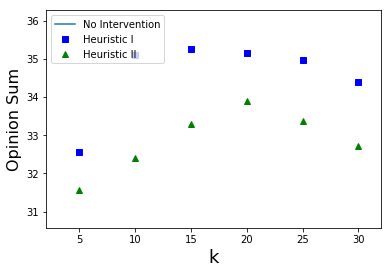

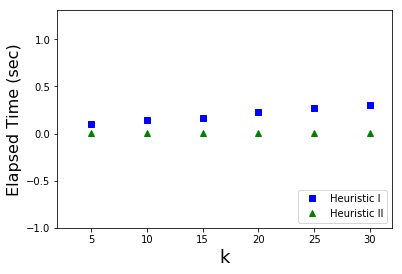

In [43]:
Results = runRealData_Heuristics('./datasets/')

# Plotting

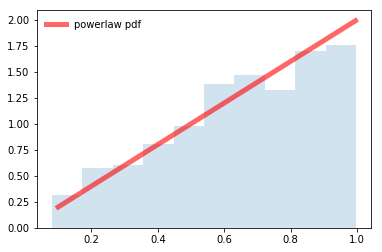

In [44]:
fig, ax = plt.subplots(1, 1)
n = 379
s, ign = powerlaw_opinions(n,2)
y = np.linspace(powerlaw.ppf(0.01, slope),powerlaw.ppf(0.99, slope), 100)
ax.plot(y, powerlaw.pdf(y, slope),'r-', lw=5, alpha=0.6, label='powerlaw pdf')
ax.hist(s, normed=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()